In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Load and preprocess the dataset
data = pd.read_csv('Datasets/Combined_News_DJIA.csv')

# Concatenate all the news headlines into a single string for each record
# Optimized by directly using pandas functionality
data['All_Headlines'] = data.iloc[:, 2:].fillna('').apply(lambda x: ' '.join(x), axis=1)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

# Define a custom Dataset class for tokenization and batching
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.headlines)
    
    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders for batch processing
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=df['All_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as pad token

MAX_LEN = 128
BATCH_SIZE = 16

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id  # Configuring pad token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# Training function with model evaluation on validation data
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

# Function to evaluate the model on validation data
def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
EPOCHS = 10
best_val_accuracy = 0
early_stopping_counter = 0
early_stopping_limit = 3

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        len(train_df)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(val_df)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    if val_acc > best_val_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_val_accuracy = val_acc
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > early_stopping_limit:
        print("Early stopping, reloading checkpoint model")
        model.load_state_dict(torch.load('best_model_state.bin'))
        break

# Evaluation function and accuracy calculation
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds)
            real_values.extend(d["labels"])
    
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------


Training: 100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


Train loss 1.5428572657704354 accuracy 0.5047140163419234


Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


Val loss 0.7767880678176879 accuracy 0.49748743718592964
Epoch 2/10
----------


Training: 100%|██████████| 100/100 [03:35<00:00,  2.16s/it]


Train loss 0.7394733986258507 accuracy 0.5285983658076682


Evaluating: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


Val loss 0.7452288174629211 accuracy 0.5175879396984925
Epoch 3/10
----------


Training: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


Train loss 0.7026491641998291 accuracy 0.5424261470773099


Evaluating: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


Val loss 0.782865309715271 accuracy 0.4623115577889447
Epoch 4/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.6681033796072007 accuracy 0.6033940917661847


Evaluating: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


Val loss 0.7924038624763489 accuracy 0.4623115577889447
Epoch 5/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.6450721737742424 accuracy 0.6134506599622879


Evaluating: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


Val loss 0.834170663356781 accuracy 0.4648241206030151
Epoch 6/10
----------


Training: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Train loss 0.6084088540077209 accuracy 0.6693903205531112


Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]

Val loss 0.8662115001678466 accuracy 0.46733668341708545
Early stopping, reloading checkpoint model


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Load the best saved model (if early stopping occurred)
model.load_state_dict(torch.load('best_model_state.bin'))

# Test the best model to get the final classification report and accuracy
test_predictions, test_real_values = evaluate(model, val_data_loader, device)
print(classification_report(test_real_values, test_predictions))
print("Test Accuracy:", accuracy_score(test_real_values, test_predictions))

              precision    recall  f1-score   support

           0       0.45      0.61      0.52       171
           1       0.60      0.45      0.52       227

    accuracy                           0.52       398
   macro avg       0.53      0.53      0.52       398
weighted avg       0.54      0.52      0.52       398

Test Accuracy: 0.5175879396984925


In [32]:
# Function to evaluate the model on test data
def evaluate(model, data_loader, device):
    model.eval()
    
    predictions = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds)
            real_values.extend(labels)
    
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

# Testing the model with a small sample from the validation set
test_sample = val_df.sample(n=5).reset_index(drop=True)
test_data_loader = create_data_loader(test_sample, tokenizer, MAX_LEN, 1)  # Single batch size for individual assessment

predictions, real_values = evaluate(model, test_data_loader, device)

# Print predictions and actual labels
for i in range(len(predictions)):
    print(f"Headline: {test_sample['All_Headlines'].iloc[i]}")
    print(f"Predicted sentiment: {'Increase' if predictions[i] == 1 else 'Decrease'}")
    print(f"Actual movement: {'Increase' if real_values[i] == 1 else 'Decrease'}")
    print("---")


Headline: Scientists claim to have broken the absolute speed barrier - particles travelling faster than the speed of light. The "first" Syrian woman (18 years old) to be killed in custody - decapitated, arms cut off, and skin removed - all to put pressure on her activist brother to turn himself in. Bill Clinton: Netanyahu to blame for failure of peace process In a suburb of Vancouver, anti-war activists are protesting that George W. Bush not be allowed in the city for an upcoming summit, calling him a mass murderer. Muslim nations demand Israel open its nuke program to IAEA viewing Wikileaks cables: Chevron tried to shake off multibillion environmental claims in Ecuador by lobbying government officials, even as it blasted opponents for allegedly playing to the courts' corrupt and political side A man who burned to death in his home died as a result of spontaneous combustion, an Irish coroner has ruled. It is believed to be the first case of its kind in Ireland. Polio outbreaks in China

In [33]:
def predict_headline(model, tokenizer, headline, device, max_len=128):
    model.eval()  # Put the model in evaluation mode

    # Tokenizing the headline
    encoding = tokenizer.encode_plus(
        headline,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass, get the logits
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    # Convert logits to probabilities (optional)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted index
    predicted_index = torch.argmax(probabilities, dim=-1).item()
    predicted_probability = probabilities[:, predicted_index].item()

    return {
        'headline': headline,
        'prediction': 'Increase' if predicted_index == 1 else 'Decrease',
        'probability': predicted_probability
    }

# Example of testing an individual headline
headline = "Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns."
result = predict_headline(model, tokenizer, headline, device)
print(f"Headline: {result['headline']}")
print(f"Predicted Movement: {result['prediction']}")
print(f"Prediction Probability: {result['probability']:.2f}")

# Major Bank Faces Regulatory Scrutiny Over Fraud Allegations. Tech Giant's Revenue Plummets Following Weak Quarterly Earnings Report. 
# Global Markets Tumble Amidst Rising Geopolitical Tensions. 
# Investor Confidence Hits New Low as Recession Fears Intensify. Cryptocurrency Exchange Files for Bankruptcy After Cyber Attack. 
# Oil Prices Crash Due to Unexpected Surge in Global Supply. Retail Giant Closes Hundreds of Stores Nationwide Amid Sales Decline. 
# Housing Market Slump Continues as Mortgage Rates Soar. Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns. 
# Start-Up Valuations Plummet as Venture Capital Funding Dries Up.


Headline: Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns.
Predicted Movement: Decrease
Prediction Probability: 0.80


Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.61      0.52       171
           1       0.60      0.45      0.52       227

    accuracy                           0.52       398
   macro avg       0.53      0.53      0.52       398
weighted avg       0.54      0.52      0.52       398

Accuracy Score: 0.5175879396984925


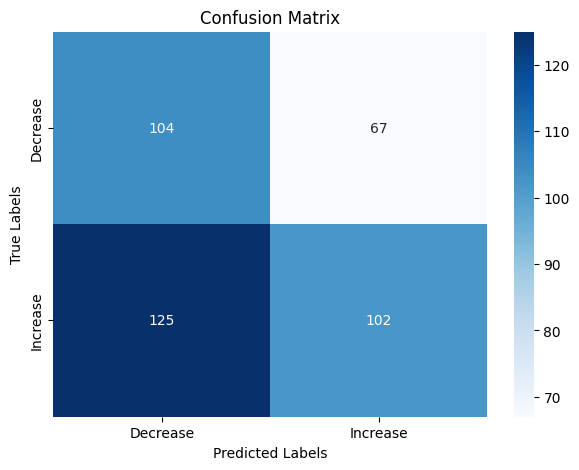

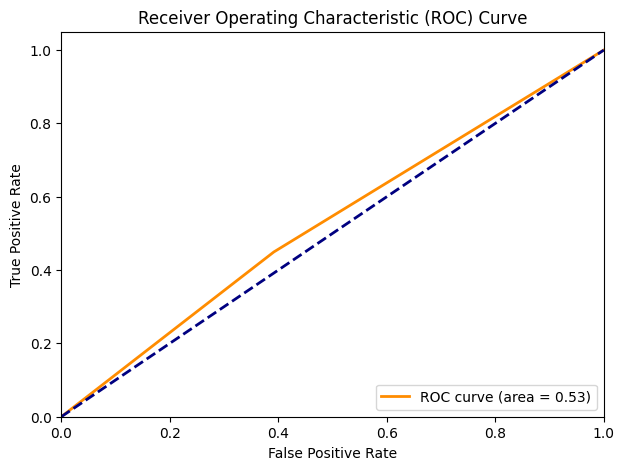

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

def evaluate_and_visualize(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    
    # Evaluation metrics
    print("Classification Report:\n", classification_report(real_values, predictions))
    print("Accuracy Score:", accuracy_score(real_values, predictions))

    # Confusion matrix
    cf_matrix = confusion_matrix(real_values, predictions)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(real_values, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the test data loader if not already done
# No need to define test_df, use val_df instead
test_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
  # test_df needs to be defined

# Call the evaluation and visualization function
evaluate_and_visualize(model, test_data_loader, device)
